# Notebook
## Sistem Rekomendasi Obat berdasarkan _Weighted Hybrid Approach_

Notebook ini menyajikan penerapan dan eksperimentasi _weighted hybrid approach_ pada sistem rekomendasi obat. _Weighted hybrid approach_ yang diusulkan merupakan kombinasi antara _content-based filtering_  dan _collaborative filtering_. Beberapa teknik pembobotan yang akan dimasukkan dalam eksperimentasi antara lain _optimal weight_.

## 1. Pustaka

Impor pustaka yang dibutuhkan.

In [1]:
# pustaka eksternal
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.spatial.distance import pdist, squareform
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# pustaka custom
from analysis import *

## 2. Persiapan Set Data

Pada bagian ini, dilakukan persiapan set data yang dibutuhkan dalam penelitian. Karena set data yang sesuai untuk secara langsung digunakan dalam penelitian ini belum tersedia saat penelitian ini dikerjakan, maka Peneliti melakukan pengumpulan data dari beberapa sumber dan menggabungkannya.

Set data `WebMD` dan `DailyMed` digabungkan dalam struktur data DataFrame.

In [2]:
# berkas WebMD Drug Reviews oleh Rohan Harode dari Kaggle
path_wmd = "data/webmd.csv"

# berkas DailyMed Drug dari situs web DailyMed
# yang dikompilasi dengan menggunakan generate_dailymed.py
path_dm = "data/dailymed.csv"

df_wmd = pd.read_csv(path_wmd)
df_dm = pd.read_csv(path_dm)

Atribut yang diperlukan sebagai pelengkap data pada DailyMed, antara lain:
1. nama obat secara umum pada kolom `sub_name`
2. daftar bahan aktif pada kolom `list_activeIngredient`, dan 
3. daftar bahan inaktif pada kolom `list_activeIngredient`.

Oleh karena itu, perlu dilakukan seleksi kolom pada DataFrame `df_dm` sebagai berikut.

In [3]:
df_dm = df_dm[["SubName", "ListActiveIngredient", "ListInactiveIngredient"]]

## 3. Prapemrosesan
...

### Data Integration

Tahap pertama pada data integration yaitu melakukan integrasi set data DailyMed dan WebMD pada _df_drugs_

In [4]:
df_drugs = pd.merge(df_dm, df_wmd, left_on = "SubName", right_on = "Drug")

### Data Selection

Tahap kedua dalam pra-pemrosesan yaitu data selection dikarenakan memfokuskan pada atribute yang akan digunakan pada penelitian 

In [5]:
list_sufficient = [val for val, cnt in df_drugs["Drug"].value_counts().iteritems() if cnt >= 500]
df_drugs_sub = df_drugs[df_drugs["Drug"].isin(list_sufficient)]

### Cleaning Data

Tahap pertama pada proses _cleaning data_ yaitu dengan mengubah nilai pada kolom `ListActiveIngredient` ke dalam bentuk _one-hot encoding vector_. _One-hot encoding_ mengubah fitur kategorikal/nominal ke format yang lebih sesuai digunakan dalam algoritma klasifikasi dan regresi. Dalam sistem rekomendasi ini, algoritma klasifikasi digunakan sebagai pembentuk model _hybrid_. 

In [6]:
def active_ingredient_text_cleaning(txt_in):
    txt_out = txt_in.replace("[[", "")
    txt_out = txt_out.replace("]]", "")
    list_out = txt_out.split("], [")
    list_out = [[j.strip("\'") for j in i.split(",")][0].lower() for i in list_out]
    return list_out

list_active_ingredients = []
for i in df_drugs_sub['ListActiveIngredient']:
    list_active_ingredients.append(active_ingredient_text_cleaning(i))

# hapus kolom list active ingredient
df_drugs_sub = df_drugs_sub.drop(columns = ["ListActiveIngredient"])
# buat kolom active ingredients berdasarkan list active ingredients
df_drugs_sub["ActiveIngredients"] = list_active_ingredients

Kemudian mengubah nilai pada kolom `ListInactiveIngredient` ke dalam bentuk _one-hot encoding vector_, sama seperti pada `ListActiveIngredient`. 

In [7]:
def inactive_ingredient_text_cleaning(txt_in):
    txt_out = txt_in.replace("[[", "")
    txt_out = txt_out.replace("]]", "")
    list_out = txt_out.split("], [")
    list_out = [[j.strip("\'") for j in i.split(",")][0].lower() for i in list_out]
    return list_out

list_inactive_ingredients = []
for i in df_drugs_sub['ListInactiveIngredient']:
    list_inactive_ingredients.append(inactive_ingredient_text_cleaning(i))

# hapus kolom list inactive ingredient
df_drugs_sub = df_drugs_sub.drop(columns = ["ListInactiveIngredient"])
# buat kolom inactive ingredients berdasarkan list inactive ingredients
df_drugs_sub["InactiveIngredients"] = list_inactive_ingredients

Langkah berikutnya yaitu mengubah nilai pada kolom `sides` ke dalam bentuk _one-hot encoding vector_, sama seperti pada `ListActiveIngredient` dan `ListInactiveIngredient`. 

In [8]:
def sides_text_cleaning(txt_in):
    # ganti whitespace lebih dari 1 menjadi 1 
    txt_out = re.sub('\s+', ' ', txt_in)
    # hapus kalimat keterangan
    txt_out = txt_out.replace("If any of these effects persist or worsen, tell your doctor or pharmacist promptly.", "")
    txt_out = txt_out.replace("If any of these effects last or get worse, tell your doctor or pharmacist promptly.", "")
    txt_out = txt_out.replace("may occur, especially during the first 2 hours after you take the medication .", "")
    txt_out = txt_out.replace("may occur as your body adjusts to this medication .", "")
    txt_out = txt_out.replace("may occur as your body adjusts to the medication .", "")
    txt_out = txt_out.replace("may also occur.", "")
    txt_out = txt_out.replace("may occur.", "")
    txt_out = txt_out.replace("and ", "")
    txt_out = txt_out.replace("your ", "")
    txt_out = txt_out.replace("or ", "")
    return txt_out

list_sides = []
for id, val in df_drugs_sub["Sides"].iteritems():
    # pembersihan text sides dan tokenisasi text sides
    list_sides.append([i.strip().lower() for i in sides_text_cleaning(val).split(",")])

# hapus kolom sides yang lama
df_drugs_sub = df_drugs_sub.drop(columns = ["Sides"])
# buat kolom sides yang baru berdasarkan list sides
df_drugs_sub["Sides"] = list_sides

## Data Tranformation

Pada `df_drugs` terdapat 1.051 baris data dengan nilai atribut `Age` dan `Sex` yang kosong. Oleh karena itu, dilakukan imputasi dengan menggunakan Simple Imputer.

In [9]:
# label encoding map untuk nilai pada sex
map_sex = {"Male":0, "Female":1}
# label encoding map untuk nilai pada age
map_age = {'0-2':0,
           '3-6':1,
           '7-12':2,
           '13-18':3,
           '19-24':4,
           '25-34':5,
           '35-44':6,
           '45-54':7,
           '55-64':8,
           '65-74':9,
           '75 or over':10}

df_tmp = df_drugs_sub.copy()
# label encoding pada sex
df_tmp["Sexmap"] = df_tmp["Sex"].map(map_sex)
# label encoding pada age
df_tmp["Agemap"] = df_tmp["Age"].map(map_age)

# inverted label encoding map untuk nilai pada sex
inv_map_sex = {v: k for k, v in map_sex.items()}
# inverted label encoding map untuk nilai pada age
inv_map_age = {v: k for k, v in map_age.items()}

# penanganan missing values pada sex dan age
# imp = KNNImputer(n_neighbors=1)
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
mat = imp.fit_transform(df_tmp[["Agemap", "Sexmap", "Satisfaction"]])
df_tmp2 = pd.DataFrame(mat, columns=["NewAge", "NewSex", "NewSatisfaction"])
df_drugs_sub["Sex"] = df_tmp2["NewSex"].map(inv_map_sex).tolist()
df_drugs_sub["Age"] = df_tmp2["NewAge"].map(inv_map_age).tolist()

# reset index setiap baris
df_drugs_sub = df_drugs_sub.reset_index(drop=True)

### Pembagian set data

Untuk menerapkan _item-based collaborative filtering_ pada sistem rekomendasi obat, dibutuhkan matriks pengguna/obat. Pada matriks tersebut terdapat _"user id"_, _"drug id"_, dan _"drug rating"_. Ilustrasi matriks tersebut adalah sebagai berikut.

|  | drug<sub>1</sub> | drug<sub>2</sub> | drug<sub>3</sub> |
| :---: | :---: | :---: | :---: |
| user<sub>1</sub> | rating<sub>user<sub>1</sub>,drug<sub>1</sub></sub> | rating<sub>user<sub>1</sub>,drug<sub>2</sub></sub> | rating<sub>user<sub>1</sub>,drug<sub>3</sub></sub> |
| user<sub>2</sub> | rating<sub>user<sub>2</sub>,drug<sub>1</sub></sub> | rating<sub>user<sub>2</sub>,drug<sub>2</sub></sub> | rating<sub>user<sub>2</sub>,drug<sub>3</sub></sub> |
| user<sub>3</sub> | rating<sub>user<sub>3</sub>,drug<sub>1</sub></sub> | rating<sub>user<sub>3</sub>,drug<sub>2</sub></sub> | rating<sub>user<sub>3</sub>,drug<sub>3</sub></sub> |
| user<sub>4</sub> | rating<sub>user<sub>4</sub>,drug<sub>1</sub></sub> | rating<sub>user<sub>4</sub>,drug<sub>2</sub></sub> | rating<sub>user<sub>4</sub>,drug<sub>3</sub></sub> |
| user<sub>5</sub> | rating<sub>user<sub>5</sub>,drug<sub>1</sub></sub> | rating<sub>user<sub>5</sub>,drug<sub>2</sub></sub> | rating<sub>user<sub>5</sub>,drug<sub>3</sub></sub> |


_"user id"_ tidak tersedia dalam `df_drugs`. Oleh karena itu, ....

_"drug id"_ tersedia dalam `df_drugs`. Oleh karena itu, ....

_"drug rating"_ tidak tersedia dalam `df_drugs`. Oleh karena itu, ....

In [10]:
# Data Drug
df_item = pd.DataFrame({'Drug':df_drugs_sub['Drug'],
                        'ActiveIngredients':df_drugs_sub['ActiveIngredients'],
                        'InactiveIngredients':df_drugs_sub['InactiveIngredients'],
                        'Sides':df_drugs_sub['Sides']})

# buat duplikat df_item, yaitu df_tmp
df_tmp = df_item.copy()
# ubah nilai ActiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['ActiveIngredients'] = [" ".join(i) for i in df_tmp['ActiveIngredients']]
# ubah nilai InactiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['InactiveIngredients'] = [" ".join(i) for i in df_tmp['InactiveIngredients']]
# ubah nilai Sides dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['Sides'] = [" ".join(i) for i in df_tmp['Sides']]
# hapus baris data duplikat pada df_tmp dan simpan index
# baris data yang dipertahankan dalam list_index
list_index = list(df_tmp.drop_duplicates().index)
# gunakan list_index yang didapatkan untuk memfilter
# baris data pada df_item
df_item = df_item.iloc[list_index]
# reset index setiap baris
df_item = df_item.reset_index(drop=True)
# buat kolom ItemId berdasarkan index setiap baris
df_item["ItemId"] = df_item.index + 1
# rapikan posisi kolom dengan memindahkan 
# posisi kolom "ItemId" ke kolom pertama
df_item = df_item[['ItemId','Drug','ActiveIngredients','InactiveIngredients','Sides']]
df_item.head()

,ItemId,Drug,ActiveIngredients,InactiveIngredients,Sides
0,1,isosorbide mononitrate,[isosorbide mononitrate],"[lactose, talc, silicon dioxide, cellulose, al...","[headache, dizziness, lightheadedness, nausea,..."
1,2,isosorbide mononitrate,[isosorbide mononitrate],"[silicon dioxide, hydrogenated castor oil, hyp...","[headache, dizziness, lightheadedness, nausea,..."
2,3,isosorbide mononitrate,[isosorbide mononitrate],[[]],"[headache, dizziness, lightheadedness, nausea,..."
3,4,isosorbide mononitrate,[isosorbide mononitrate],"[silicon dioxide, hydrogenated castor oil, hyp...","[headache, dizziness, lightheadedness, nausea,..."
4,5,prednisone,[prednisone],"[lactose monohydrate, magnesium stearate, micr...","[nausea, vomiting, loss of appetite, heartburn..."


In [11]:
# Data User
df_user = pd.DataFrame({'Age':df_drugs_sub['Age'],
                        'Sex':df_drugs_sub['Sex'],
                        'Condition':df_drugs_sub['Condition']})

# buat kolom UserId berdasarkan index setiap baris
df_user["UserId"] = df_user.index + 1
# rapikan posisi kolom dengan memindahkan 
# posisi kolom "UserId" ke kolom pertama
df_user = df_user[['UserId','Age','Sex','Condition']]
df_user.head()

,UserId,Age,Sex,Condition
0,1,75 or over,Male,Other
1,2,55-64,Female,Other
2,3,75 or over,Male,Angina Pectoris Prevention
3,4,75 or over,Male,Angina Pectoris Prevention
4,5,75 or over,Male,Angina Pectoris Prevention


In [12]:
# Data Rating
df_tmp2 = df_drugs_sub.copy()
# ubah nilai ActiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp2['ActiveIngredients'] = [" ".join(i) for i in df_tmp2['ActiveIngredients']]
# ubah nilai InactiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp2['InactiveIngredients'] = [" ".join(i) for i in df_tmp2['InactiveIngredients']]
# ubah nilai Sides dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp2['Sides'] = [" ".join(i) for i in df_tmp2['Sides']]

df_tmp = df_item.copy()
# ubah nilai ActiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['ActiveIngredients'] = [" ".join(i) for i in df_tmp['ActiveIngredients']]
# ubah nilai InactiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['InactiveIngredients'] = [" ".join(i) for i in df_tmp['InactiveIngredients']]
# ubah nilai Sides dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['Sides'] = [" ".join(i) for i in df_tmp['Sides']]

df_rating = df_tmp2.merge(df_tmp,
                          how="left",
                          on=["Drug", "ActiveIngredients", "InactiveIngredients", "Sides"])
df_rating["UserId"] = df_user["UserId"]
df_rating = df_rating[['UserId',
                       'ItemId',
                       'EaseofUse',
                       'Effectiveness',
                       'Satisfaction']]
df_rating.head()

,UserId,ItemId,EaseofUse,Effectiveness,Satisfaction
0,1,1,1,1,1
1,2,1,1,5,1
2,3,1,5,5,5
3,4,1,5,5,5
4,5,1,5,5,5


In [13]:
# one hot encoding pada kolom Condition
one_hot = pd.get_dummies(df_user['Condition'])
# hapus kolom Condition karena saat ini sudah di-encode
df_user = df_user.drop('Condition', axis = 1)
# gabungkan hasil encode ke df_user
df_user = df_user.join(one_hot)

# one hot encoding pada kolom Sex
one_hot = pd.get_dummies(df_user['Sex'])
# hapus kolom Sex karena saat ini sudah di-encode
df_user = df_user.drop('Sex', axis = 1)
# gabungkan hasil encode ke df_user
df_user = df_user.join(one_hot)

# ordinal label encoding map untuk nilai pada Age
map_age = {'0-2':0,
           '3-6':1,
           '7-12':2,
           '13-18':3,
           '19-24':4,
           '25-34':5,
           '35-44':6,
           '45-54':7,
           '55-64':8,
           '65-74':9,
           '75 or over':10}
df_tmp = df_user.copy()
# label encoding pada Age
df_user["Age"] = df_tmp["Age"].map(map_age)

In [14]:
# one-hot encoding pada kolom ActiveIngredients
mlb = MultiLabelBinarizer()
df_item = df_item.join(pd.DataFrame(mlb.fit_transform(df_item.pop("ActiveIngredients")),
                                    columns=mlb.classes_,
                                    index=df_item.index))

# one-hot encoding pada kolom InactiveIngredients
mlb = MultiLabelBinarizer()
df_item = df_item.join(pd.DataFrame(mlb.fit_transform(df_item.pop("InactiveIngredients")),
                                    columns=mlb.classes_,
                                    index=df_item.index))

# one-hot encoding pada kolom Sides
mlb = MultiLabelBinarizer()
df_item = df_item.join(pd.DataFrame(mlb.fit_transform(df_item.pop("Sides")),
                                    columns=mlb.classes_,
                                    index=df_item.index))

# hapus kolom Drug (id=1), [] (id=23), " " (id=100)
df_item = df_item.drop(df_item.iloc[:, [1, 23, 100]], axis=1)

## 5. Pembangunan Model Rekomendasi

Pada tahap pembangunan model rekomendasi, data dibagi menjadi 70% data latih dan sisanya 30% data uji


In [15]:
# 70% baris data dipilih secara random 
# sebagai data train dan sisanya sebagai data test
df_rating_train = df_rating.sample(frac = 0.7)
df_rating_train = df_rating_train.reset_index(drop=True)
df_rating_test = df_rating.drop(df_rating_train.index)
df_rating_test = df_rating_test.reset_index(drop=True)

In [16]:
x_train = df_rating_train[['UserId', 'ItemId']]
y_train = df_rating_train[['Satisfaction']]
x_test = df_rating_test[['UserId', 'ItemId']]
y_test = df_rating_test['Satisfaction']

In [17]:
# merge df_item dan df_user untuk masing-masing set data latih dan uji
x_train = x_train.join(df_user.set_index('UserId'),
                       on = 'UserId').join(df_item.set_index('ItemId'),
                                           on = 'ItemId')

x_test = x_test.join(df_user.set_index('UserId'),
                     on = 'UserId').join(df_item.set_index('ItemId'),
                                         on = 'ItemId')

x_train digabung untuk mengambil semua atribute pada dataframe user dan dataframe item dengan menggunakan UserId dan ItemId

### Recommendation Model Setting

#### Content-based Filtering based on Random Forest

In [18]:
# model 1
model1 = RandomForestClassifier()
model1.fit(x_train.iloc[:, 2:x_train.shape[1]].values, 
           y_train["Satisfaction"].values)

RandomForestClassifier()

Model1 rekomendasi yang digunakan untuk content-based filtering adalah RandomForestClasifier

#### Collaborative-based Filtering based on k-Nearest Neighbors

In [19]:
# model 2
model2 = KNeighborsClassifier(metric='cosine',)
model2.fit(x_train.iloc[:, 2:x_train.shape[1]].values, 
           y_train["Satisfaction"].values)

KNeighborsClassifier(metric='cosine')

Model2 rekomendasi yang digunakan untuk Collaborative-based Filtering based on k-Nearest Neigboard adalah KNeighborsClassifier

## 6. Pengujian Model Rekomendasi

...

#### Content-based Filtering based on Random Forest

In [20]:
pred1 = model1.predict(x_test.iloc[:, 2:x_test.shape[1]].values)
rmse = np.sqrt(np.mean((pred1 - y_test.to_numpy())**2))
print("content-based rmse = %.2f" %rmse)
# pi = 1.898557915518256
# print("PI = %.2f" % pi)

content-based rmse = 1.91


#### Collaborative-based Filtering based on k-Nearest Neighbors

In [25]:
pred2 = model2.predict(x_test.iloc[:, 2:x_test.shape[1]].values)
rmse = np.sqrt(np.mean((pred2 - y_test.to_numpy())**2))
print("content-based rmse = %.2f" %rmse)

content-based rmse = 1.93


#### Hybrid

Gunakan fungsi `linspace` pada NumPy untuk membuat sekuens _weight_.

Text(0, 0.5, 'RMSE')

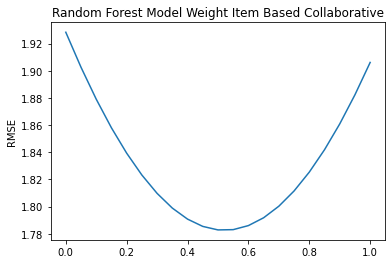

In [22]:
chart_val = []

w = np.linspace(0,1,21)

for i in w:
    pred3 = pred1*i + pred2*(1-i)
    rmse = np.sqrt(np.mean((pred3 - y_test.to_numpy())**2))
    chart_val.append([i, rmse])

chart_val_np = np.array(chart_val)
plt.plot(chart_val_np[:, 0], chart_val_np[:,1])
plt.title('Random Forest Model Weight Item Based Collaborative')
plt.ylabel('RMSE')

In [23]:
#chart_val_np

Dapat dilihat bahwa _weight_ terbaik (RMSE terkecil) adalah di antara `0,4` s.d. `0.6`.

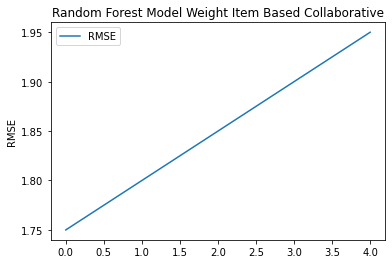

In [24]:
#COBA
plt.plot([1.75, 1.80, 1.85, 1.90, 1.95], label='RMSE')
plt.title('Random Forest Model Weight Item Based Collaborative')
plt.ylabel('RMSE')
plt.yticks([1.75, 1.80, 1.85, 1.90, 1.95])
plt.legend(loc = 'best')
plt.show()

---